In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import KFold
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

In [2]:
def get_precision_recall(predictions, t, threshold):
    user_predict = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_predict[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_predict.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        G = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        S_t = t
        intersect = sum((est >= threshold) for (est, _) in user_ratings[:t])
        #print('S_t:  ' + str(S_t) + "  " + str(intersect / S_t))
        precisions[uid] = intersect / S_t 
        recalls[uid] = intersect / G 
    
    avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
    avg_recall = sum(recall for recall in recalls.values()) / len(recalls)
    
    return avg_precision, avg_recall
        


In [3]:
def preprocess_test(testdata, least_t, threshold):
    user_rating_count = {}
    movie_love_count = {}
    for (user, movie, rating) in testdata:
        if user not in user_rating_count:
            user_rating_count[user] = 0
        if user not in movie_love_count:
            movie_love_count[user] = 0
        
        user_rating_count[user] += 1
        if rating >= threshold:
            movie_love_count[user] += 1
    
    trim_test = []
    for (user, movie, rating) in testdata:
        if user_rating_count[user] >= least_t and movie_love_count[user] > 0:
            trim_test.append((user, movie, rating))
    
    return trim_test


In [4]:
file_name = 'ratings.csv'#Please change this path into absolute path to "ratings.csv"
data_raw = pd.read_csv(file_name)
data_table = data_raw.pivot_table(values = 'rating', index = ['userId'], columns = ['movieId'], fill_value=0)
data_mat = pd.DataFrame.as_matrix(data_table)
movieId = list(data_table.columns)
userId = list(data_table.index)

D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [5]:
reader = Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
data = Dataset.load_from_file(file_name, reader=reader)
ts = [i for i in range(1, 26)]
thres = 3

In [6]:
def ranking(data, model, kf, thres):
    precs = []
    recs = []
    for t in ts:
        print('t:  ' + str(t))
        prec_t = []
        rec_t = []
        for train, test in kf.split(data):
            model.fit(train)
            trim_test = preprocess_test(test, t, threshold = thres)
            predictions = model.test(trim_test)
            avg_prec_t, avg_rec_t = get_precision_recall(predictions, t, thres)
            prec_t.append(avg_prec_t)
            rec_t.append(avg_rec_t)
        precs.append(np.mean(prec_t))
        recs.append(np.mean(rec_t))
        print('avg_prec: ' + str(np.mean(prec_t)))
        print('avg_rec: ' + str(np.mean(rec_t)))
        
    return precs, recs

In [7]:
def plot(ts, precision, recall, method):
    plt.plot(ts, precision)
    plt.xlabel('t', fontsize=15)
    plt.ylabel('Average Precision', fontsize=15)
    plt.title("Precision vs t for " + method)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig('precision vs t for ' + str(method) + '.png', dpi=300, bbox_inches = 'tight')

    plt.plot(ts, recall)
    plt.xlabel('t', fontsize=15)
    plt.ylabel('Average Recall', fontsize=15)
    plt.title("Recall vs t for " + method)
    fig2 = plt.gcf()
    plt.show()
    fig2.savefig('recall vs t for ' + str(method) + '.png', dpi=300, bbox_inches = 'tight')

    plt.plot(recall, precision)
    plt.xlabel('Average Recall', fontsize=15)
    plt.ylabel('Average Precision', fontsize=15)
    plt.title("Precision vs Recall for " + method)
    fig3 = plt.gcf()
    plt.show()
    fig3.savefig('Precision vs Recall for ' + str(method) + '.png', dpi=300, bbox_inches = 'tight')

In [8]:
kf = KFold(n_splits=10)
sim_options = {'name': 'pearson'}
knn = KNNWithMeans(k = 22, sim_options=sim_options, verbose = False)
prec_knn, rec_knn = ranking(data, knn, kf, thres)

t:  1
avg_prec: 0.981434564118465
avg_rec: 0.23158545064732397
t:  2
avg_prec: 0.9690501270600343
avg_rec: 0.37259822926292996
t:  3
avg_prec: 0.9639242166076528
avg_rec: 0.4468616642824905
t:  4
avg_prec: 0.9624686128886429
avg_rec: 0.4815108352396197
t:  5
avg_prec: 0.9608873823023426
avg_rec: 0.501869491201346
t:  6
avg_prec: 0.9591275179678906
avg_rec: 0.5168366936857013
t:  7
avg_prec: 0.9580935247796253
avg_rec: 0.5253214609392965
t:  8
avg_prec: 0.9576992790323381
avg_rec: 0.5369973184418417
t:  9
avg_prec: 0.9581624186670584
avg_rec: 0.5492593182127665
t:  10
avg_prec: 0.9517754026631999
avg_rec: 0.5576124706109762
t:  11
avg_prec: 0.9546432725702431
avg_rec: 0.5679142916463941
t:  12
avg_prec: 0.9516214111252115
avg_rec: 0.5765886568043729
t:  13
avg_prec: 0.9527634245899195
avg_rec: 0.5857958841462066
t:  14
avg_prec: 0.9511390695789468
avg_rec: 0.5919431522904757
t:  15
avg_prec: 0.9506583631620167
avg_rec: 0.5955234736550479
t:  16
avg_prec: 0.9494902878552814
avg_rec: 0.60

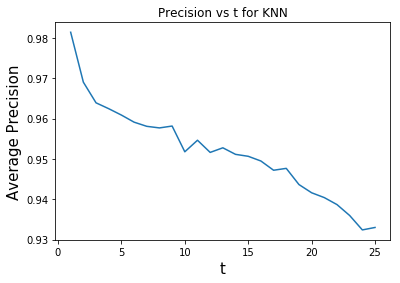

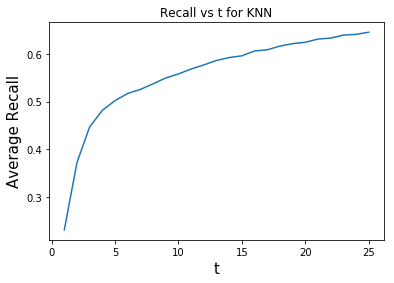

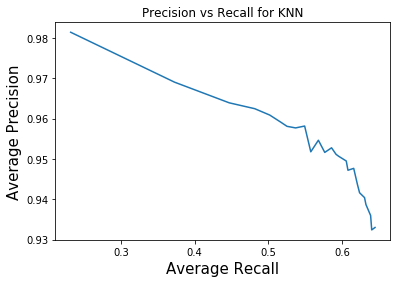

In [9]:
plot(ts, prec_knn, rec_knn, "KNN")

In [11]:
kf = KFold(n_splits=10)
nnmf = NMF(n_factors=22, biased = False)
prec_nnmf, rec_nnmf = ranking(data, nnmf, kf, thres)

t:  1
avg_prec: 0.9813652639155401
avg_rec: 0.2304186202014678
t:  2
avg_prec: 0.9724298594721896
avg_rec: 0.3713937124594562
t:  3
avg_prec: 0.9665901425131915
avg_rec: 0.44858540735665076
t:  4
avg_prec: 0.9650088871118905
avg_rec: 0.4797614417861323
t:  5
avg_prec: 0.9629591770969942
avg_rec: 0.5024685505247806
t:  6
avg_prec: 0.9636428357810841
avg_rec: 0.5180452804292385
t:  7
avg_prec: 0.9640174691798047
avg_rec: 0.5287638528771808
t:  8
avg_prec: 0.9628932574909816
avg_rec: 0.5374253302595318
t:  9
avg_prec: 0.9597401028924202
avg_rec: 0.5524652857529991
t:  10
avg_prec: 0.9598143739888709
avg_rec: 0.5638387698278576
t:  11
avg_prec: 0.9587442840786858
avg_rec: 0.5754137108866957
t:  12
avg_prec: 0.9580433839055953
avg_rec: 0.5831006134192378
t:  13
avg_prec: 0.9563588359231874
avg_rec: 0.5828688468354307
t:  14
avg_prec: 0.9568739636588015
avg_rec: 0.5965086988167146
t:  15
avg_prec: 0.9560807063894169
avg_rec: 0.6022237815874911
t:  16
avg_prec: 0.9571977000062658
avg_rec: 0.6

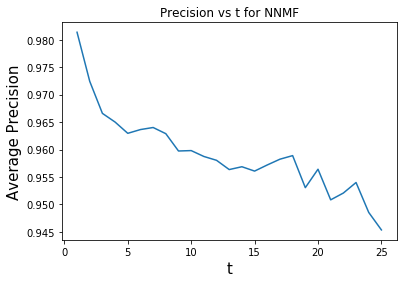

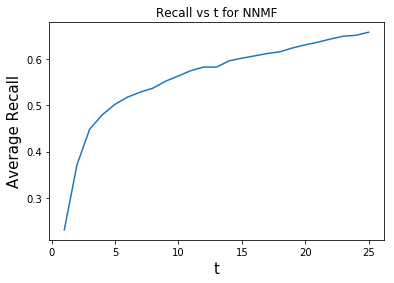

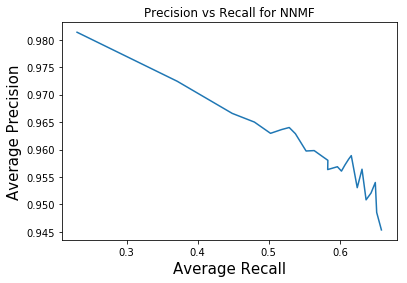

In [12]:
plot(ts, prec_nnmf, rec_nnmf, "NNMF")

In [13]:
kf = KFold(n_splits=10)
nmf_biased = SVD(n_factors=18, biased = True)
prec_mf, rec_mf = ranking(data, nmf_biased, kf, thres)


t:  1
avg_prec: 0.9804514289522135
avg_rec: 0.22826964478800305
t:  2
avg_prec: 0.9694722206186018
avg_rec: 0.3789286783838325
t:  3
avg_prec: 0.9650636921602578
avg_rec: 0.45711682206125454
t:  4
avg_prec: 0.9625576766757797
avg_rec: 0.49002923972101814
t:  5
avg_prec: 0.9615007238803361
avg_rec: 0.5020883774950955
t:  6
avg_prec: 0.9615855167350869
avg_rec: 0.5129424881614632
t:  7
avg_prec: 0.9577934010827903
avg_rec: 0.5301544438887722
t:  8
avg_prec: 0.9538995823751477
avg_rec: 0.5325623131399587
t:  9
avg_prec: 0.953450724553784
avg_rec: 0.5454668702552488
t:  10
avg_prec: 0.9532767412518389
avg_rec: 0.5562285937973633
t:  11
avg_prec: 0.9527915389246451
avg_rec: 0.5666305531611837
t:  12
avg_prec: 0.9485042831458189
avg_rec: 0.5726335760801766
t:  13
avg_prec: 0.9458034032042614
avg_rec: 0.5797207913106074
t:  14
avg_prec: 0.9475503206385538
avg_rec: 0.5857141861919113
t:  15
avg_prec: 0.9475584999350014
avg_rec: 0.594095382935976
t:  16
avg_prec: 0.9462486332825746
avg_rec: 0.5

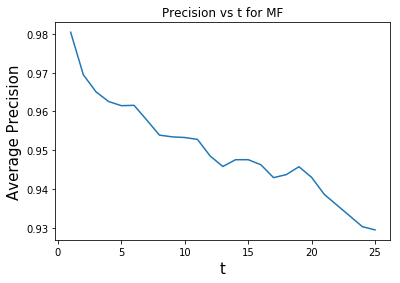

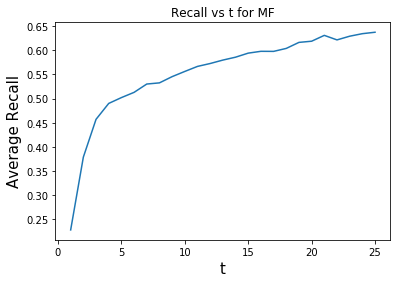

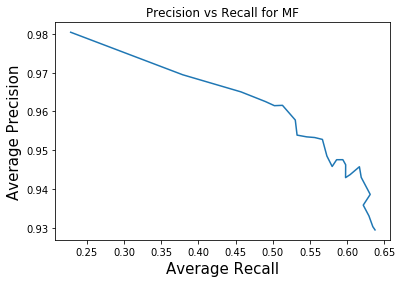

In [15]:
plot(ts, prec_mf, rec_mf, "MF")

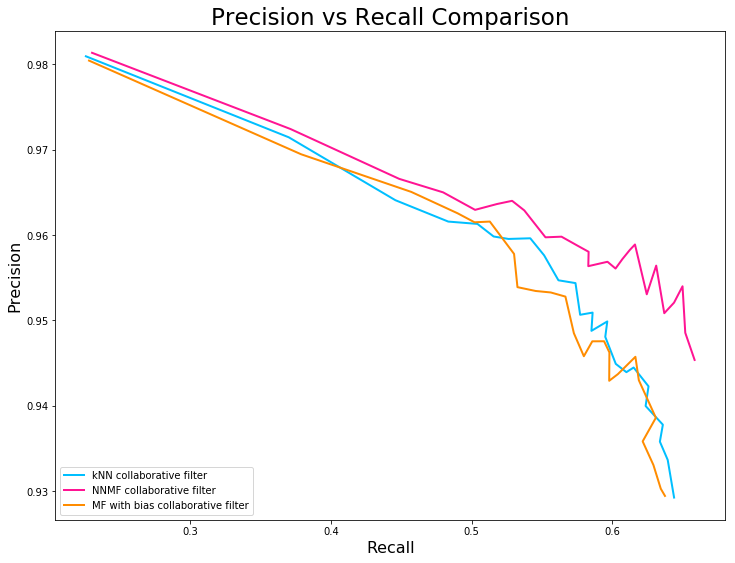

In [16]:
plt.figure(figsize=(12,9))
plt.plot(rec_knn, prec_knn, color='deepskyblue', lw=2, label='kNN collaborative filter')
plt.plot(rec_nnmf, prec_nnmf, color='deeppink', lw=2, label='NNMF collaborative filter')
plt.plot(rec_mf, prec_mf, color='darkorange', lw=2, label='MF with bias collaborative filter')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision vs Recall Comparison', fontsize=23)
plt.legend(loc="lower left")
fig = plt.gcf()
plt.show()
fig.savefig('Precision vs Recall Comparison.png', dpi=300, bbox_inches = 'tight')